# Super Resolution with OpenVINO

[Super Resolution Model description](https://github.com/openvinotoolkit/open_model_zoo/blob/develop/models/intel/single-image-super-resolution-1032/description/single-image-super-resolution-1032.md)

## Preparation

### Imports

In [1]:
import os
import time
import urllib
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, FileLink
from IPython.display import Image as DisplayImage
from IPython.display import Pretty, ProgressBar, clear_output, display
from openvino.inference_engine import IECore
from PIL import Image

### Settings

In [2]:
# Device to use for inference. For example, "CPU", or "GPU"
DEVICE = "CPU"
# 1032: 4x superresolution, 1033: 3x superresolution
MODEL_FILE = "models/single-image-super-resolution-1032.xml"
model_name = os.path.basename(MODEL_FILE)
model_xml_path = Path(MODEL_FILE).with_suffix(".xml")

### Functions


In [3]:
def write_text_on_image(image: np.ndarray, text: str) -> np.ndarray:
    """
    Write the specified text in the top left corner of the image
    as white text with a black border.

    :param image: image as numpy arry with HWC shape, RGB or BGR
    :param text: text to write
    :return: image with written text, as numpy array
    """
    font = cv2.FONT_HERSHEY_PLAIN
    org = (20, 20)
    font_scale = 4
    font_color = (255, 255, 255)
    line_type = 1
    font_thickness = 2
    text_color_bg = (0, 0, 0)
    x, y = org

    image = cv2.UMat(image)
    (text_w, text_h), _ = cv2.getTextSize(
        text, font, font_scale, font_thickness
    )
    result_im = cv2.rectangle(
        image, org, (x + text_w, y + text_h), text_color_bg, -1
    )

    textim = cv2.putText(
        result_im,
        text,
        (x, y + text_h + font_scale - 1),
        font,
        font_scale,
        font_color,
        font_thickness,
        line_type,
    )
    return textim.get()


def load_image(path: str) -> np.ndarray:
    """
    Loads an image from `path` and returns it as BGR numpy array.

    :param path: path to an image filename or url
    :return: image as numpy array, with BGR channel order
    """
    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block requests
        # with User-Agent Python
        request = urllib.request.Request(
            path, headers={"User-Agent": "Mozilla/5.0"}
        )
        response = urllib.request.urlopen(request)
        array = np.asarray(bytearray(response.read()), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image


def convert_result_to_image(result) -> np.ndarray:
    """
    Convert network result of floating point numbers to image with integer
    values from 0-255. Values outside this range are clipped to 0 and 255.

    :param result: a single superresolution network result in N,C,H,W shape
    """
    result = result.squeeze(0).transpose(1, 2, 0)
    result *= 255
    result[result < 0] = 0
    result[result > 255] = 255
    result = result.astype(np.uint8)
    return result


def to_rgb(image_data) -> np.ndarray:
    """
    Convert image_data from BGR to RGB
    """
    return cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

## Load the superresolution model

Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

The Super Resolution model expects two inputs: 1) the input image, 2) a bicubic interpolation of the input image to a size of 1920x1080. It returns the super resolution version of the image in 1920x1800 (for the default superresolution model (1032)). 

Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

In [4]:
ie = IECore()
net = ie.read_network(
    str(model_xml_path), str(model_xml_path.with_suffix(".bin"))
)
exec_net = ie.load_network(network=net, device_name=DEVICE)

Get information about network inputs and outputs. The Super Resolution model expects two inputs: 1) the input image, 2) a bicubic interpolation of the input image to the target size 1920x1080. It returns the super resolution version of the image in 1920x1800. 

In [20]:
# Network inputs and outputs are dictionaries. Get the keys for the
# dictionaries.
original_image_key = list(exec_net.input_info)[0]
bicubic_image_key = list(exec_net.input_info)[1]
output_key = list(exec_net.outputs.keys())[0]

# Get the expected input and target shape. `.dims[2:]` returns the height
# and width. OpenCV's resize function expects the shape as (width, height),
# so we reverse the shape with `[::-1]` and convert it to a tuple
input_height, input_width = tuple(
    exec_net.input_info[original_image_key].tensor_desc.dims[2:]
)
target_height, target_width = tuple(
    exec_net.input_info[bicubic_image_key].tensor_desc.dims[2:]
)

upsample_factor = int(target_height / input_height)

print(
    f"The network expects inputs with a width of {input_width}, "
    f"height of {input_height}"
)
print(
    f"The network returns images with a width of {target_width}, "
    f"height of {target_height}"
)

print(
    f"The image sides are upsampled by a factor {upsample_factor}. "
    f"The new image is {upsample_factor**2} times as large as the "
    "original image"
)

The network expects inputs with a width of 480, height of 270
The network returns images with a width of 1920, height of 1080
The image sides are upsampled by a factor 4. The new image is 16 times as large as the original image


In [6]:
ie = IECore()
net = ie.read_network(
    str(model_xml_path), str(model_xml_path.with_suffix(".bin"))
)
exec_net = ie.load_network(network=net, device_name=DEVICE)

In [7]:
# Network inputs and outputs are dictionaries. Get the keys for the
# dictionaries.
original_image_key = list(exec_net.input_info)[0]
bicubic_image_key = list(exec_net.input_info)[1]
output_key = list(exec_net.outputs.keys())[0]

# Get the expected input and target shape. `.dims[2:]` returns the height
# and width. OpenCV's resize function expects the shape as (width, height),
# so we reverse the shape with `[::-1]` and convert it to a tuple
input_height, input_width = tuple(
    exec_net.input_info[original_image_key].tensor_desc.dims[2:]
)
target_height, target_width = tuple(
    exec_net.input_info[bicubic_image_key].tensor_desc.dims[2:]
)

upsample_factor = int(target_height / input_height)

print(
    f"The network expects inputs with a width of {input_width}, "
    f"height of {input_height}"
)
print(
    f"The network returns images with a width of {target_width}, "
    f"height of {target_height}"
)

print(
    f"The image sides are upsampled by a factor {upsample_factor}. "
    f"The new image is {upsample_factor**2} times as large as the "
    "original image"
)

The network expects inputs with a width of 480, height of 270
The network returns images with a width of 1920, height of 1080
The image sides are upsampled by a factor 4. The new image is 16 times as large as the original image


## Load and show the input image

Showing full image with width 585 and height 727


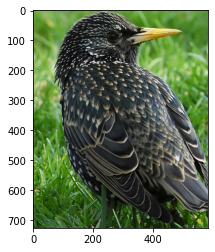

In [8]:
IMAGE_PATH = Path("images/im_99.bmp")
full_image = load_image(str(IMAGE_PATH))

# Uncomment these lines to load a raw image as BGR
# import rawpy
# with rawpy.imread(IMAGE_PATH) as raw:
#     full_image = raw.postprocess()[:,:,(2,1,0)]

plt.imshow(to_rgb(full_image))
print(
    f"Showing full image with width {full_image.shape[1]} "
    f"and height {full_image.shape[0]}"
)

## Superresolution on one crop of the image

### Take one crop of the input image

Take a crop of network input size. Give the X (width) and Y (height) coordinates for the top left corner of the crop. Set the CROP_FACTOR variable to 2 to make a crop that is larger than the network input size. This is useful for very high resolution images, where a crop of network input size is too small to show enough information.

Showing image crop with width 480 and height 270.


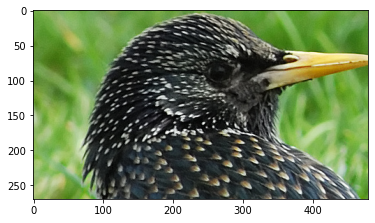

In [9]:
CROP_FACTOR = 1

image_id = "bird"
starty = 0
startx = 0

# Perform the crop
image_crop = full_image[
    starty : starty + input_height * CROP_FACTOR,
    startx : startx + input_width * CROP_FACTOR,
]

# Show the cropped image
print(
    f"Showing image crop with width {image_crop.shape[1]} and "
    f"height {image_crop.shape[0]}."
)
plt.imshow(to_rgb(image_crop));

### Reshape/resize crop for network input

The input image is resized to network input size, and reshaped to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images). The image is also resized to network output size, with bicubic interpolation. This bicubic image is the second input to the network.

In [10]:
# Resize the image to the target shape with bicubic interpolation
bicubic_image = cv2.resize(
    image_crop, (target_width, target_height), interpolation=cv2.INTER_CUBIC
)

# If required, resize image to input image shape
if CROP_FACTOR > 1:
    image_crop = cv2.resize(image_crop, (input_width, input_height))

# Reshape the images from (H,W,C) to (N,C,H,W)
input_image_original = np.expand_dims(image_crop.transpose(2, 0, 1), axis=0)
input_image_bicubic = np.expand_dims(bicubic_image.transpose(2, 0, 1), axis=0)

### Do inference

Do inference and convert the inference result to an RGB image

In [11]:
network_result = exec_net.infer(
    inputs={
        original_image_key: input_image_original,
        bicubic_image_key: input_image_bicubic,
    }
)
# Get inference result as numpy array and reshape to image shape and data type
result_image = convert_result_to_image(network_result[output_key])

### Show and save results

Show the bicubic image, the enhanced superresolution image, and the difference between the bicubic and the superresolution image. 

Text(0.5, 1.0, 'Bicubic/Superresolution difference')

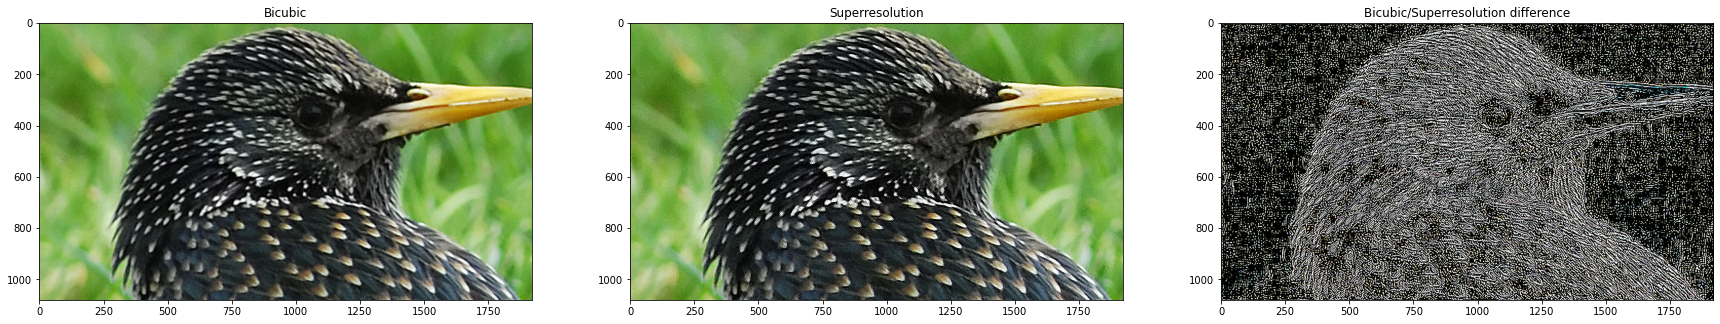

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(30, 15))
ax[0].imshow(to_rgb(bicubic_image))
ax[1].imshow(to_rgb(result_image))
ax[2].imshow(to_rgb(bicubic_image - result_image))
ax[0].set_title("Bicubic")
ax[1].set_title("Superresolution")
ax[2].set_title("Bicubic/Superresolution difference")

#### Save superresolution and bicubic image crop

In [13]:
# Add text with "SUPER" or "BICUBIC" to the superresolution or bicubic image
image_super = write_text_on_image(result_image, "SUPER")
image_bicubic = write_text_on_image(bicubic_image, "BICUBIC")

# Store the image and the results
crop_image_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_{image_id}_{upsample_factor}x_crop.png"
)
superres_image_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_{image_id}_{upsample_factor}x_crop_superres.png"
)
bicubic_image_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_{image_id}_{upsample_factor}x_crop_bicubic.png"
)

cv2.imwrite(str(crop_image_path), image_crop, [cv2.IMWRITE_PNG_COMPRESSION, 0])
cv2.imwrite(
    str(superres_image_path), image_super, [cv2.IMWRITE_PNG_COMPRESSION, 0]
)
cv2.imwrite(
    str(bicubic_image_path), image_bicubic, [cv2.IMWRITE_PNG_COMPRESSION, 0]
)
print(f"Images written to directory: {IMAGE_PATH.parent}")

Images written to directory: images


#### Write animated gif with bicubic/superresolution comparison

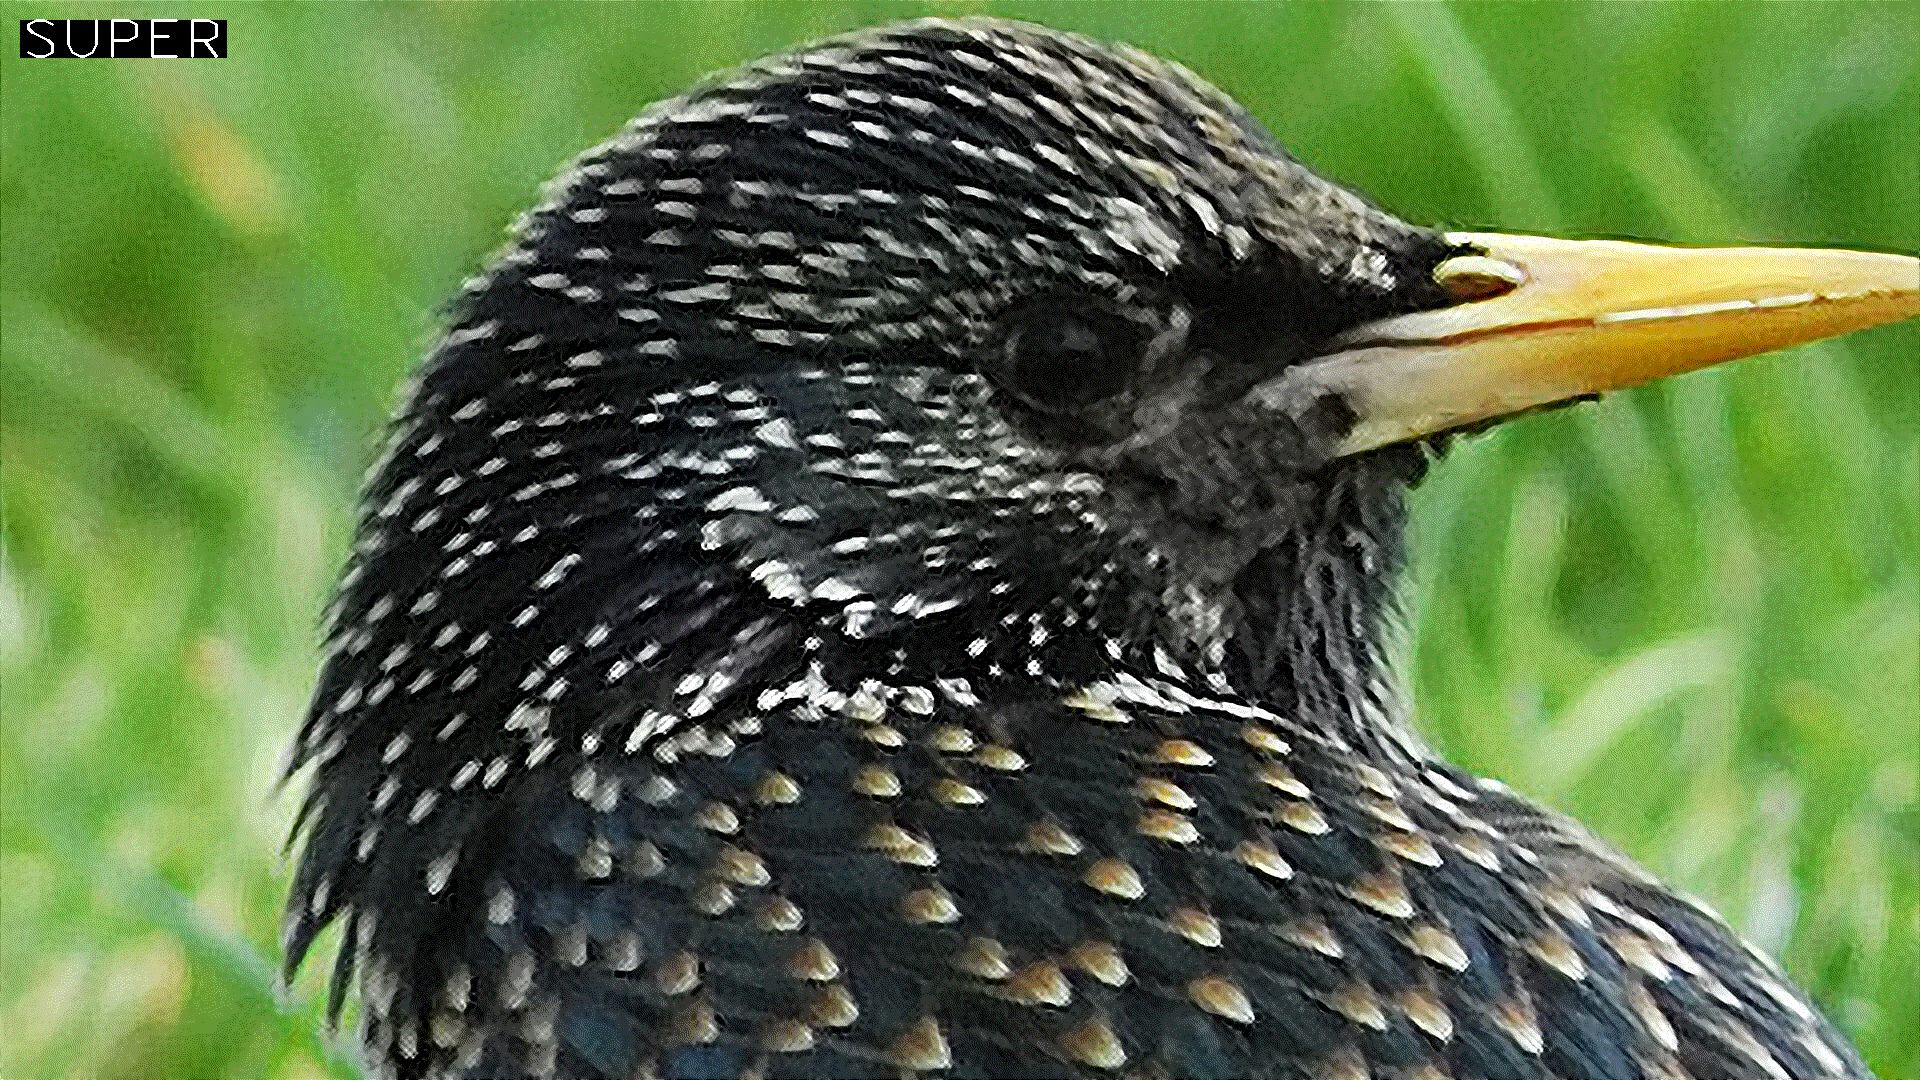

In [14]:
result_pil = Image.fromarray(to_rgb(image_super))
bicubic_pil = Image.fromarray(to_rgb(image_bicubic))
gif_image_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_{image_id}_comparison_{upsample_factor}x.gif"
)

result_pil.save(
    fp=str(gif_image_path),
    format="GIF",
    append_images=[bicubic_pil],
    save_all=True,
    duration=1000,
    loop=0,
)

# DisplayImage(str(gif_image_path)) doesn't work in Colab
DisplayImage(open(gif_image_path, "rb").read(), width=1920 // 2)

#### Create video with sliding bicubic/superresolution comparison

This may take a while. For the video, the superresolution and bicubic image are resized by a factor two to improve processing speed. This gives an indication of the superresolution effect. The video is saved as an .avi video. You can click on the link to download the video, or open it directly from the images directory, and play it locally.

In [15]:
FOURCC = cv2.VideoWriter_fourcc(*"MJPG")

result_video_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_{image_id}_crop_comparison_{upsample_factor}x.avi"
)
video_target_height, video_target_width = (
    result_image.shape[0] // 2,
    result_image.shape[1] // 2,
)

out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,
    90,
    (video_target_width, video_target_height),
)

resized_result_image = cv2.resize(
    result_image, (video_target_width, video_target_height)
)
resized_bicubic_image = cv2.resize(
    bicubic_image, (video_target_width, video_target_height)
)

progress_bar = ProgressBar(total=video_target_width)
progress_bar.display()

for i in range(video_target_width):
    # Create a frame where the left part (until i pixels width) contains the
    # superresolution image, and the right part (from i pixels width) contains
    # the bicubic image
    comparison_frame = np.hstack(
        (
            resized_result_image[:, :i, :],
            resized_bicubic_image[:, i:, :],
        )
    )
    # create a small black border line between the superresolution
    # and bicubic part of the image
    comparison_frame[:, i - 1 : i + 1, :] = 0
    out_video.write(comparison_frame)
    progress_bar.progress = i
    progress_bar.update()
out_video.release()
clear_output()

video_link = FileLink(result_video_path)
video_link.html_link_str = "<a href='%s' download>%s</a>"
display(HTML(f"The video has been saved to {video_link._repr_html_()}"))

## Superresolution on full input image

Superresolution on the full image is done by dividing the image into patches of equal size, doing superresolution on each path, and then stitching the resulting patches together again. For this demo, patches near the border of the image are ignored.

Adjust the `CROPLINES` setting in the next cell if you see boundary effects

### Compute patches

In [16]:
# Set the number of lines to crop from the network result to prevent
# boundary effects. Should be an integer >= 1.
CROPLINES = 15
full_image_height, full_image_width = full_image.shape[:2]

# Compute x and y coordinates of left top of image tiles
x_coords = list(range(0, full_image_width, input_width - CROPLINES * 2))
while full_image_width - x_coords[-1] < input_width:
    x_coords.pop(-1)
y_coords = list(range(0, full_image_height, input_height - CROPLINES * 2))
while full_image_height - y_coords[-1] < input_height:
    y_coords.pop(-1)

# Compute the width and height to crop the full image. The full image is
# cropped at the border to tiles of input size  #TODO
crop_width = x_coords[-1] + input_width
crop_height = y_coords[-1] + input_height

# Compute the width and height of the target superresolution image
new_width = (
    x_coords[-1] * upsample_factor
    + target_width
    - CROPLINES * 2 * upsample_factor
)
new_height = (
    y_coords[-1] * upsample_factor
    + target_height
    - CROPLINES * 2 * upsample_factor
)
print(
    f"The output image will have a width of {new_width} "
    f"and a height of {new_height}"
)

The output image will have a width of 1800 and a height of 1920


### Do inference

The code in this cell reads one patch of the image at a time. Each patch is reshaped to network input shape and upsampled with bicubic interpolation to target shape. Both the original and the bicubic image are propagated through the network. The network result is a numpy array with floating point values, with a shape of (1,3,1920,1080). This array is converted to an 8-bit image with shape (1080,1920,3) and written to `full_superresolution_image`. The bicubic image is written to `full_bicubic_image` for comparison. A progress bar shows the progress of the process. Inference time is measured, as well as total time to process each patch.

In [17]:
start_time = time.perf_counter()
patch_nr = 0
num_patches = len(x_coords) * len(y_coords)
progress_bar = ProgressBar(total=num_patches)
progress_bar.display()

# Crop image to fit tiles of input size
full_image_crop = full_image.copy()[:crop_height, :crop_width, :]

# Create empty array of target size.
full_superresolution_image = np.empty(
    (new_height, new_width, 3), dtype=np.uint8
)

# Create bicubic upsampled image of target size for comparison
full_bicubic_image = cv2.resize(
    full_image_crop[CROPLINES:-CROPLINES, CROPLINES:-CROPLINES, :],
    (new_width, new_height),
    interpolation=cv2.INTER_CUBIC,
)

total_inference_duration = 0
for y in y_coords:
    for x in x_coords:
        patch_nr += 1

        image = full_image_crop[y : y + input_height, x : x + input_width]
        input_image_original = np.expand_dims(image.transpose(2, 0, 1), axis=0)

        # Resize the images to the target shape with bicubic interpolation
        bicubic_image = cv2.resize(
            image, (target_width, target_height), interpolation=cv2.INTER_CUBIC
        )

        input_image_bicubic = np.expand_dims(
            bicubic_image.transpose(2, 0, 1), axis=0
        )

        # Do inference
        inference_start_time = time.perf_counter()

        network_result = exec_net.infer(
            inputs={
                original_image_key: input_image_original,
                bicubic_image_key: input_image_bicubic,
            }
        )

        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration

        # Reshape inference result to image shape and data type
        result = network_result[output_key]
        result_image = convert_result_to_image(result)

        # Add the inference result of this patch to the full superresolution
        # image
        new_y = y * upsample_factor
        new_x = x * upsample_factor
        full_superresolution_image[
            new_y : new_y + target_height - CROPLINES * upsample_factor * 2,
            new_x : new_x + target_width - CROPLINES * upsample_factor * 2,
        ] = result_image[
            CROPLINES * upsample_factor : -CROPLINES * upsample_factor,
            CROPLINES * upsample_factor : -CROPLINES * upsample_factor,
            :,
        ]

        progress_bar.progress = patch_nr
        progress_bar.update()

        if patch_nr % 10 == 0:
            clear_output(wait=True)
            progress_bar.display()
            display(
                Pretty(
                    f"Processed patch {patch_nr}/{num_patches}. "
                    f"Inference time: {inference_duration:.2f} seconds "
                    f"({1/inference_duration:.2f} FPS)"
                )
            )

end_time = time.perf_counter()
duration = end_time - start_time
clear_output(wait=True)
print(
    f"Processed {num_patches} patches in {duration:.2f} seconds. "
    f"Total patches per second (including processing): "
    f"{num_patches/duration:.2f}.\nInference patches per second: "
    f"{num_patches/total_inference_duration:.2f} "
)

Processed 2 patches in 1.18 seconds. Total patches per second (including processing): 1.69.
Inference patches per second: 2.06 


### Save superresolution image and the bicubic image

In [18]:
full_superresolution_image_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_full_superres_{upsample_factor}x.jpg"
)
full_bicubic_image_path = IMAGE_PATH.with_name(
    f"{IMAGE_PATH.stem}_full_bicubic_{upsample_factor}x.jpg"
)
cv2.imwrite(str(full_superresolution_image_path), full_superresolution_image)
cv2.imwrite(str(full_bicubic_image_path), full_bicubic_image);

In [19]:
bicubic_link = FileLink(full_bicubic_image_path)
image_link = FileLink(full_superresolution_image_path)
bicubic_link.html_link_str = "<a href='%s' download>%s</a>"
image_link.html_link_str = "<a href='%s' download>%s</a>"
display(
    HTML(
        "The images are saved in the images directory. You can also download "
        "them by clicking on these links:"
        f"<ul><li>{image_link._repr_html_()}<li>{bicubic_link._repr_html_()}"
    )
)